# Computing features to train a MLP
This notebook will guide you through the use of the `keras` package to train a multilayer perceptron for handwritten digits classification. You are going to computing the histogram of gradients from the images in the `mnist` dataset (LeCun et al. 1998)

## Loading the packages

In [185]:
%pip install tensorflow --upgrade
%pip install keras --upgrade

import numpy as np
from matplotlib import pyplot as pl

from skimage.feature import hog
from skimage import data, color, exposure

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical

%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Load the `mnist` dataset and normalize in the range [0, 1]

In [186]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = to_categorical(y_train, n_classes)
Y_test = to_categorical(y_test, n_classes)

60000 train samples
10000 test samples


### An example of how to compute the histogram of gradients
Let's compute the HOG for one image in the test dataset

In [187]:
n_orientations = 4
pix_p_cell = 7
hog_size = int(height * width * n_orientations / (pix_p_cell * pix_p_cell))

In [188]:
fd, hog_image = hog(X_test[0,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

Show the image and the corresponding gradients

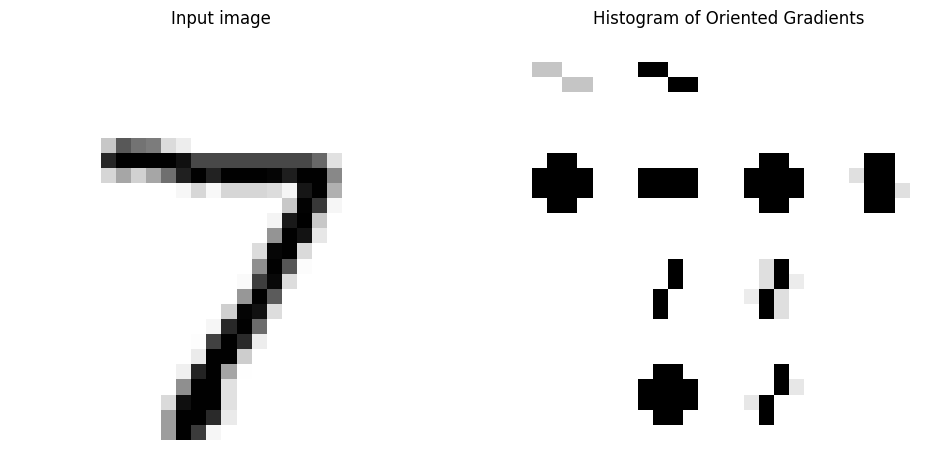

In [189]:
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(X_test[0,:,:,0], cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax1.set_title('Input image')
ax1.set_adjustable('box')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')

Compute the HOGs for the train and test datasets


In [190]:
X_train_hog = np.zeros((X_train.shape[0], hog_size))
X_test_hog = np.zeros((X_test.shape[0], hog_size))

for i in np.arange(X_train_hog.shape[0]):
    X_train_hog[i,:] = hog(X_train[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_train done')

for i in np.arange(X_test_hog.shape[0]):
    X_test_hog[i,:] = hog(X_test[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_test done')

X_train done
X_test done


Create the MLP

In [195]:
model = Sequential()
model.add(Dense(100, input_shape=(hog_size,), activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

C:\Users\Anthony\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_66 (Dense)                │ (None, 100)            │         6,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,510 (29.34 KB)

 Trainable params: 7,510 (29.34 KB)

 Non-trainable params: 0 (0.00 B)

Define some constants and train the MLP

In [196]:
from keras.src.optimizers import AdamW

batch_size = 64
n_epoch = 10

model.compile(loss='categorical_crossentropy', optimizer=AdamW(), metrics=['accuracy'])

history = model.fit(X_train_hog, Y_train, batch_size=batch_size, epochs=n_epoch, verbose=1, validation_split=0.3)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7090 - loss: 1.0946 - val_accuracy: 0.8978 - val_loss: 0.3325
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - accuracy: 0.9031 - loss: 0.3114 - val_accuracy: 0.9071 - val_loss: 0.2868
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9097 - loss: 0.2820 - val_accuracy: 0.9164 - val_loss: 0.2613
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step - accuracy: 0.9143 - loss: 0.2657 - val_accuracy: 0.9164 - val_loss: 0.2548
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 945us/step - accuracy: 0.9177 - loss: 0.2520 - val_accuracy: 0.9148 - val_loss: 0.2575
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step - accuracy: 0.9234 - loss: 0.2380 - val_accuracy: 0.9193 - val_loss: 0.2481
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step - accuracy: 0.9247 - loss: 0.2310 - val_accuracy: 0.9241 - val_loss: 0.2342
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 979us/step - accuracy: 0.9247 - loss: 0.2290 - val_

Show the performance of the model

Test score: 0.20233184099197388
Test accuracy: 0.9340999722480774


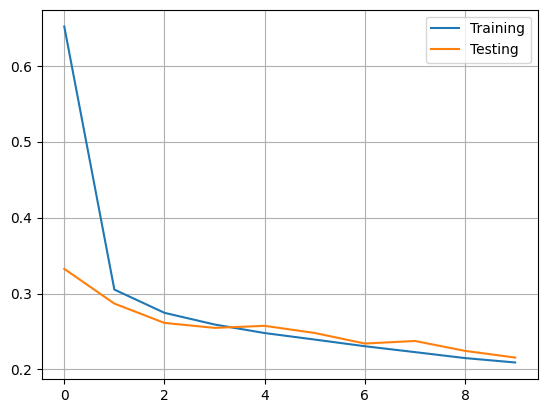

In [197]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test_hog, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Confusion matrix

In [198]:
from sklearn.metrics import confusion_matrix

pred = model.predict(X_test_hog)
pred = np.argmax(pred, axis=-1)
confusion_matrix(y_test, pred)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


array([[ 955,    2,    2,    0,    0,    1,    9,    1,    6,    4],
       [   1, 1110,    2,    3,    4,    1,    7,    2,    5,    0],
       [   6,    7,  955,   27,    6,    3,    3,   13,   10,    2],
       [   3,    2,   10,  942,    2,   13,    0,    6,   28,    4],
       [   0,    5,    4,    2,  928,    0,    2,    5,    2,   34],
       [   4,    0,    1,   35,    3,  812,    7,    0,   25,    5],
       [  16,    2,    1,    0,   12,   15,  899,    0,   12,    1],
       [   0,    3,   22,    5,    9,    0,    0,  933,    9,   47],
       [  10,    5,    7,   26,    5,   22,    9,    3,  873,   14],
       [   3,    5,    2,   15,   13,    6,    0,   23,    8,  934]],
      dtype=int64)